---
layout: single
title: "Handling Missing Data"
header:
categories:
  - ML
author_profile: false
---

# Handling Mislabelled Data - A simple look into the current research

A common problem on the jounrey of creating Machine Learning systems is handling mislabelled or missing data. Most common form on missing labels are NaN. 

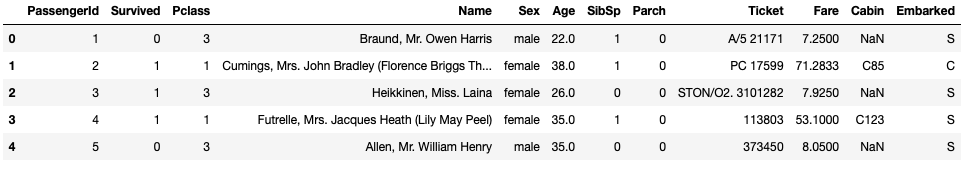

In [3]:
from IPython.display import Image
Image(filename='../assets/images/handling_missing_label/missing_label_picture_one.png')

This Titanic dataset, obtained from Kaggle, reveals that the "Cabin" feature has three NaN entries within the first five rows, suggesting a high likelihood of more missing values throughout the dataset.

So, what are some logical options for handling missing data?

1. Removing Entries: Deleting rows with missing values is a straightforward approach. However, for smaller datasets, this might significantly reduce the available data, potentially leading to loss of valuable information.

2. Leaving It: Ignoring missing data might introduce inaccuracies in machine learning models. It's crucial to assess the impact of missing values on the model's performance.

3. Manually assigning values to missing entries: This becomes impractical with a large number of NaN values. Additionally, human error and subjectivity can affect the accuracy of this approach.

# How does the industry deal with this?

Well a great resource by Chip Huyen in the book [ML system design](https://huyenchip.com/machine-learning-systems-design/toc.html) states when handling missing labels there are usually 4 main solutions

1. ### Weak Supervision 
    1. __What__ : Creating Labelling functions which are build on heurisitcs which automatically classifies label inputs based on a algorithm 
    2. __Example__ : Given a person in the hospitcal, the nurse write a note of what is probably happening to paitent, the doctors then makes his suggestion based on the nurses note 
    3. __When__ : By creating Labelling function, it ensure the you have to go throuhg all labels one by one, imrpoving privacy of data time 
    4. __Problems__: the accuracy is allot lower then handlabelling and it takes time to build a comprehensive labelling function
2. ### Semi-Supervised 
    1. __What__ : Process of handlabelling a small subset of data and then using regression to label the remaining data
    2. __types__: 
        1. __Self-training__ : Model trains on features with valid inputs, then using regression on remaining 
        2. __Clustering labels__: finding data with similar features then using those features
    3. __When__: This methods according to Chip is the most reliable, and can emulate results of hand-labelling
    4. __Problems__: takes time and knowledge to make self-training/Clustering labels
3. ### Transfer Learning
    1. __What__ : process of using a pretrained model previously used that is simlar to the current problem to label data
    4. __Problems__ : You need a privously model similar to the current objective
4. ### Active Learning
    1. __What__ : building upon Semi surpervised in a sense, we started of with some unlabelled data. We then hand label a subset of the features and allow a Ml algorithm to pridict is label, which is just some probaibilty of the likelihood of the output label being correct/incorrect.All label which the ml has low confidence on a person evaluates these labels and then resend them to the model with the correct labels if needed, this iterative process continus happening until the ml is able to adequately label data. Then this is used on the remaining unlabeled data
    4. __Problems__: requires hand labelling of initial subset data and continual data. Additionally, the model maybe become confident its predicted label is correct even though it isn't which can become undetected. 
    

# Application - Building these ML algorithms
While not traditional in the next section i will implement these techniques for inputing missing features rather then labels. In this case the most applicable to the Titanic data is Active Learning and Semi-Supervised 

## Step 1 - Finding the features which having missing inputs
To do this we need to automate this step to check if it contain Nan in any columns and output these columns. 

In [ ]:
import numpy as np 
import sklearn as sk 
import sympy as sp
import pandas as pd
import tensorflow as tp
from IPython.display import FileLink, FileLinks
from ipywidgets import FileUpload

In [6]:
# import data
train_data = pd.read_csv('../assets/datasets/handling_missing_labels/titanic/train.csv')
test_data = pd.read_csv('../assets/datasets/handling_missing_labels/titanic/test.csv')
train = pd.DataFrame(train_data)

In [7]:
# data shape 
train.shape

(891, 12)

In [8]:
# checking which columns contains  in any combination nan 
def check_entry_exist(data, col: str, entry):
    entry_exist = 0
    for row in range(train.shape[0]):
        if isinstance(data.loc[row, col], str):
            if isinstance(entry, str): 
                if data.loc[row, col].capitalize().strip() == entry.capitalize().strip():
                    print(f"{col} in {data} contains {entry}")
                    entry_exist += 1
                    break
        # some integer/float/Nan or other
        elif data.loc[row, col] == entry or (np.isnan(data.loc[row, col]) == np.isnan(entry)):
            print(f"{col} contains {entry}")
            entry_exist += 1
            break 
     
    # entry doesnt exist in data
    if entry_exist == 0:
        print(f"{col} doesn't contain {entry}")
    
    return 


print("This is for training data\n")
check_entry_exist(train, 'Embarked', np.nan)
check_entry_exist(train, 'Age', np.nan)
check_entry_exist(train, 'Cabin', np.nan)
print("\n")
check_entry_exist(train, 'Sex', np.nan)
check_entry_exist(train, 'PassengerId', np.nan)
check_entry_exist(train, 'Survived', np.nan)
check_entry_exist(train, 'Pclass', np.nan)
check_entry_exist(train, 'SibSp', np.nan)
check_entry_exist(train, 'Parch', np.nan)
check_entry_exist(train, 'Fare', np.nan)
check_entry_exist(train, 'Name', np.nan)
check_entry_exist(train, 'Ticket', np.nan)

This is for training data

Embarked contains nan
Age contains nan
Cabin contains nan


Sex doesn't contain nan
PassengerId doesn't contain nan
Survived doesn't contain nan
Pclass doesn't contain nan
SibSp doesn't contain nan
Parch doesn't contain nan
Fare doesn't contain nan
Name doesn't contain nan
Ticket doesn't contain nan


The above code creates a function check_entry_exist(data, col: str, entry) takes a input data, col which has to be a string, and entry you a trying to find and then loops thoruhg all entries in the Titanic data. 

During the loop the, the control structure will check if its a both data entry and given parameter entry are both string, ensures no extra whitespaces or different capatisliation error and output if it is found. Alternatively, if will check if there is any other datatype if function input "entry" is another other then string and it will output the if found. 

If the entry doesnt exist then it will output the entry doesn't exist

In this instance, Embarked, Age and Cabin contain missing inputs.

# Step 2 - Apply ML Algorithsm 
Based the columns that are missing data we will start with the logistics. Thinking does it makes sense that a say; 
1. Predicting age - It makes logitical sense that we can infer that based on the sex, pclass, cabin and embarked we can get a esitmate of disposal income. Assumming as people get older they have more disposal income 
2. Predicting Cabin - Most boats are sperted by sections of class, so it would makes sense pclass,survival (if say most of the pclass 1 people survived, then the cabin would be simialr)
2. Predicting Embarked - This is probablre the hardest one to predicit since the curnt columsn could give some dincation but, currently im pretty sectible

### Approach 1 - Semi-Supervised Clustering